# Imports de toutes les libraries et classes MRCNN que nous allons utiliser



In [15]:
import os
import sys
import random
import math
import re
import json
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from skimage.draw import polygon
import warnings
warnings.filterwarnings('ignore') 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

## Création de constantes utiles pour la suite du code
## Chargement du model COCO initial

In [2]:
%matplotlib inline 

ROOT_DIR = os.path.abspath("../../")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
sys.path.append(ROOT_DIR) 
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Création de la class config qui sera utilisé pour l'entrainement de notre model

In [3]:
class LighterConfig(Config):
    NAME = "lighter"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    LEARNING_RATE = 0.0001
    NUM_CLASSES = 2
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    STEPS_PER_EPOCH = 80
    VALIDATION_STEPS = 10
    
config = LighterConfig()
# La commande suivante permet d'afficher l'intégralité de la configuration utilisé dans l'entrainement
# nous la laissons commenté et vous invitons a la décommenter si vous voulez visualiser votre configuration actuelle
# Cela peut etre utile pour voir tout les attributs que vous pouvez rajouter dans la classe actuelle
# config.display() 

## Création de la class Dataset qui permet d'utiliser notre dataset (train, validation ou test) et lier chaque image a ses annotations

In [4]:
class LighterDataset(utils.Dataset):
    def load_lighters(self, dataset_dir):

        # creation de constantes qui contienne le path des images du dataset et leurs annotations
        images_dir = dataset_dir
        annotations_file = os.path.join(dataset_dir, '_annotations.coco.json')

        # Chargement du fichier d'annotation qui doit etre au format COCO
        with open(annotations_file) as f:
            annotations = json.load(f)

        # Ajout de la classe lighter
        self.add_class('lighter', 1, "lighter")
        
        # Ajout des images chargé au images de la classe
        for image_info in annotations['images']:
            image_path = os.path.join(images_dir, image_info['file_name'])
            image = Image.open(image_path)
            width, height = image.size 
            self.add_image(
                source="lighter",
                image_id=image_info['id'],
                height=height,
                width=width,
                path=image_path, 
                annotations=annotations 
            )

    def load_mask(self, image_id):
        """
        Chargement du mask pour l'image avec l'id image_id
        """
        info = self.image_info[image_id] # Recuperation des information de l'image
        # Recuperation des annotations de l'image
        image_annotations = [anno for anno in info['annotations']['annotations'] if anno['image_id'] == info['id']]

        masks = []
        class_ids = []

        for anno in image_annotations:
            # Creation d'un mask a partir du polygon dans l'annotation de l'image, pas besoin de gérer le cas RLE 
            # car toutes nos annotations sont en polygon
            mask = self.polygon_to_mask(anno['segmentation'], info['height'], info['width'])  
            masks.append(mask)
            class_ids.append(anno['category_id'])

        if len(masks) > 0:
            return np.stack(masks, axis=-1), np.array(class_ids)
        else:
            return np.empty((info['height'], info['width'], 0), dtype=np.uint8), np.array([])

    def polygon_to_mask(self, polygons, height, width):
        mask = np.zeros((height, width), dtype=np.uint8)
        for poly in polygons:
            poly = np.array(poly).reshape((len(poly) // 2, 2))
            rr, cc = polygon(poly[:, 1], poly[:, 0], mask.shape)
            mask[rr, cc] = 1
        return mask
    
    def image_reference(self, image_id):
        return self.image_info[image_id]['path'] # Recuperation du path d'une image a partir de son id

## Instanciation du model en mode training

In [5]:
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


## Instanciation des datasets train, val (pour validation) et test

In [6]:
dataset_train = LighterDataset()
dataset_train.load_lighters(dataset_dir=os.path.join(ROOT_DIR, "dataset/lighter-dataset/train/"))
dataset_train.prepare()

dataset_val = LighterDataset()
dataset_val.load_lighters(dataset_dir=os.path.join(ROOT_DIR, "dataset/lighter-dataset/valid/"))
dataset_val.prepare()

dataset_test = LighterDataset()
dataset_test.load_lighters(dataset_dir=os.path.join(ROOT_DIR, "dataset/lighter-dataset/test/"))
dataset_test.prepare()

## Lancement de l'entrainement du model

In [10]:
model.load_weights(os.path.join(ROOT_DIR, "logs/lighter20241113T2217/mask_rcnn_lighter_0010.h5"), by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc",
        "mrcnn_bbox", "mrcnn_mask"])
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')

Re-starting from epoch 1


AssertionError: Create model in training mode.

# Testing

Loading weights from  /home/mourad/studies/ia/Mask_RCNN/logs/lighter20241113T2217/mask_rcnn_lighter_0020.h5
Re-starting from epoch 20
original_image           shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  640.00000  int64
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int64
gt_bbox                  shape: (3, 4)                min:   65.00000  max:  525.00000  int32
gt_mask                  shape: (640, 640, 3)         min:    0.00000  max:    1.00000  uint8


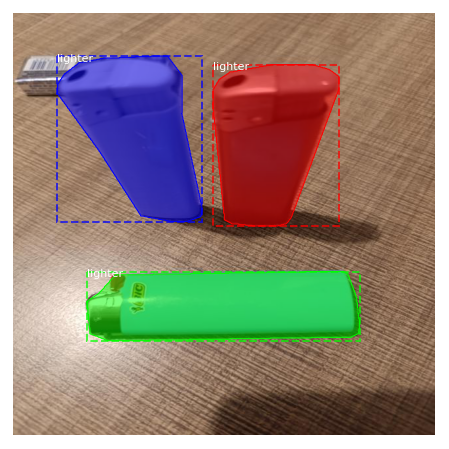

In [12]:
class InferenceConfig(LighterConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Initalisation du model en mode inference
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# path vers les poids généré par l'entrainement qu'on veut utiliser dans notre teste de detection
model_path = os.path.join(ROOT_DIR, "logs/lighter20241113T2217/mask_rcnn_lighter_0020.h5")
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Choix d'un id aléatoire pour tester le model ou choix d'un id specifique 
# image_id = random.choice(dataset_val.image_ids)
image_id = 1
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Visualisation de l'image choisi avec son annotation
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

# Detection sur l'image choisi et visualisation du resultat

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -116.80000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


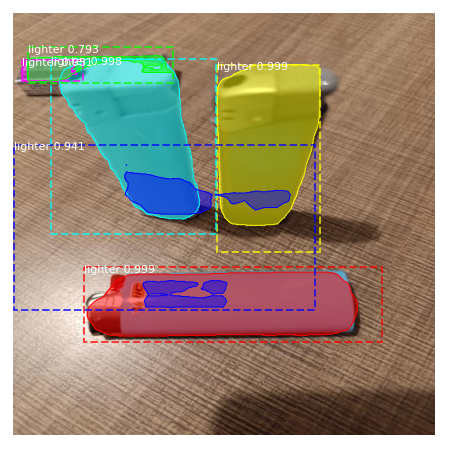

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(8, 8))

# Détection sur une image qui ne fait pas partie du dataset

Processing 1 images
image                    shape: (600, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


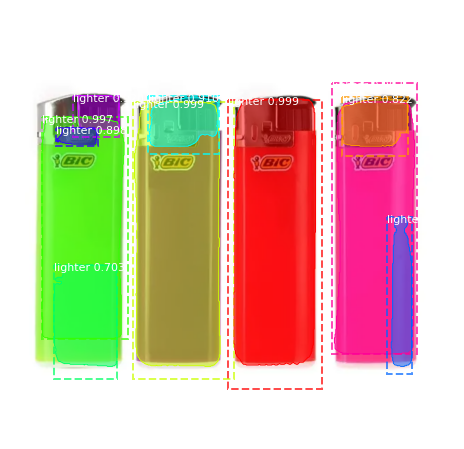

In [14]:
img_path = "../../briquet-bic-electronique.webp"

# Chargement et préparation de l'image
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Effectuer la détection
results = model.detect([image_rgb], verbose=1)

# Extraire les résultats de la détection pour l'image
r = results[0]

# Vérifier s'il y a des masques détectés
if r['masks'].shape[-1] > 0:  # Vérifier si des masques existent
    # Récupérer les masques de détection et les redimensionner à la taille de l'image
    masks_resized = []
    for i in range(r['masks'].shape[-1]):
        mask = r['masks'][:, :, i]
        resized_mask = cv2.resize(mask.astype(np.uint8), (image_rgb.shape[1], image_rgb.shape[0]))
        masks_resized.append(resized_mask)
    
    # Convertir les masques redimensionnés en un tableau NumPy
    masks_resized = np.stack(masks_resized, axis=-1)
else:
    masks_resized = None  # Pas de masques, on définit masks_resized comme None

# Visualiser l'image avec les résultats de la détection
visualize.display_instances(image_rgb, r['rois'], masks_resized, r['class_ids'], 
                            dataset_train.class_names, r['scores'], figsize=(8, 8))